In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
%matplotlib notebook
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib notebook
from noggin import create_plot
import torch
from torch import nn
import torch.nn.functional as F

from detection_utils.boxes import non_max_suppression, generate_targets
from detection_utils.metrics import compute_recall, compute_precision
from detection_utils.pytorch import softmax_focal_loss

In [65]:
import numpy as np
encodings = dict()
def one_hot(labels, item_labels):
    ''' Create one-hot encodings for each item in item_labels according to labels

        Parameters
        ----------
        labels : list shape (M,)
            list of distinct labels of which to categorize item_labels

        item_labels : list shape (X,)
            list of item labels with each element corresponding to the label of one item

        Returns
        -------
        numpy.ndarray, shape=(X, M)
            one hot encodings for each item
        '''
    onehot_encoded = list()
    for lbl in item_labels:
        item_encoded = [0 for _ in range(len(labels))]
        item_encoded[labels.index(lbl)] = 1
        #Check this: temporary fix (change back to thing listed below)
        encodings[lbl] = np.argmax(item_encoded)+1
        #encodings[lbl] = 1

with open('food_labels_raw.txt', mode="r") as var:
    all_labels = var.read().splitlines()
    distinct_labels = list(set(all_labels))
one_hot(distinct_labels, all_labels)


In [66]:

def layer_image(background, roi_image, image, shift = (0,0)):
    ''' Replaces the pixels of the foreground with the pixels of the colored image
    wherever the image region is true.
    
    Parameters
    ----------
    background : numpy.array of shape (M,N,3)
    
    roi_image : numpy.array of shape (X,Y,3) where X and Y are <= M and N.
                Elements are 1 where the object region is detected and 0 where it is not.
    
    image : numpy.array of shape (X,Y,3).
            Elements are the color of the image
    
    shift : Tuple(int, int)
                The amount of shift (down, right) from (0,0), or top left, of the background
        
    Returns
    -------
    Numpy.array of shape (M,N,3)
        Altered background array
    '''
    shift_down, shift_right = shift
    for i in range(roi_image.shape[0]):
        for j in range(roi_image.shape[1]):
            if roi_image[i][j] == 1:
                background[i + shift_down][j + shift_right] = image[i][j]
    return background

In [67]:
def propose_regions(image, threshold=0.1):
    ''' Create binary region predictions from an image.
    
    Parameters
    ----------
    image : numpy.ndarray, shape=(R, C, 3)
        The image for which to propose regions.
        
    threshold : Real ∈ [0, 1], optional (default=0.1)
        The color threshold at which to propose regions.
        
    Returns
    -------
    numpy.ndarray, shape=(R, C)
        The binary image holding regions of interest.
    '''
    
    roi_img = np.zeros(image.shape[:2], dtype=np.uint8) # shape (R, C)
    
    # regions of interest (RoIs) are where the maximum RGB difference across a single
    # pixel location is at least 0.1
    
    # get the color vector differences by taking (R, C, 3, 1) - (R, C, 1, 3)
    diffs = np.abs(image[..., np.newaxis] - image[:, :, np.newaxis, :])
    
    # find where the color difference is > 0.1
    rois = np.where(np.max(diffs, axis=(2, 3)) > 0.1)
    
    # those areas are foreground (objects)
    roi_img[rois] = 1
    return roi_img

In [133]:
def parse_food():


    rgba_pil = PIL.Image.open('food.png')
    img = np.array(rgba_pil.convert('RGB'))
    
    #new_labels is a list of tuples: (name, category)
    with open("indiv_labels.txt", mode = "r") as var:
        new_labels = var.read().splitlines()
    
    row_step = 1200 // 15
    col_step = 1280 // 16

    images = [] #list of each image's rgb arrays
    labels = np.arange(232) #list of each image's label
    
    for i in range(0, 1200, row_step):
        for j in range(0, 1280, col_step):
            images.append(img[i: i + row_step, j: j + col_step, :])
            #Check this: check order
            #labels.append(new_labels[index][0])

    images = np.array(images[:-8]) #takes out the random lack of food at last row
    # list of each regionized image where 1 indicates object and 0 indicates background
    roi_images = np.array([propose_regions(i) for i in images])

    #All labels defined above
    return images, roi_images, labels

In [134]:
image_width = 80
image_height = 80
def generate_fridge(num_items):
    """
    num_items >=0 && <=25a
    """

    images, roi_images, labels = parse_food()
    right = [shift for shift in range(30, 400, 80)]
    shelf_coord = [180, 300, 420, 540, 690]  # coordinates of the first, second ... shelves
    shift_ls = []
    for shelf in shelf_coord:
        for pos in right:
            shift_ls.append([(shelf, pos)])
    
    fridge = mpimg.imread('fridge.jpg')
    fridge = np.array(fridge)
    
    boxes_list = []
    labels_list = []
    
    for i in range(num_items):
        #rand_shelf = shelf_coord[np.random.randint(0, len(shelf_coord))]
        randint = np.random.randint(0, len(images))
        #rand_image = images[np.random.randint(0, len(images))]
        shift = shift_ls.pop(np.random.randint(0, len(shift_ls))) #random right shift
        fridge = layer_image(fridge, roi_images[randint], images[randint], shift[0])
        boxes_list.append(np.array([shift[0][1], shift[0][0], shift[0][1]+image_width, shift[0][0]+image_height], dtype=np.float32))
        labels_list.append(labels[randint])
    boxes_list = np.vstack(boxes_list)   
    plt.imshow(fridge)
    return fridge,boxes_list,np.array(labels_list)


In [135]:
set1 = [generate_fridge(np.random.randint(1,25)) for i in range(10)]
set2 = [set1[np.random.randint(0, 10)] for i in range(3)]
#set2 = [generate_fridge(np.random.randint(1,25)) for i in range(30)]


In [136]:
train_images_raw = np.array([i[0] for i in set1], dtype=np.float32)
#might not need to make a copy -- computationally expensive for later
train_images = np.copy(train_images_raw)
train_images-= np.mean(train_images_raw)
train_images/=np.std(train_images_raw)

train_boxes = np.array([i[1] for i in set1])
train_labels = np.array([ i[2] for i in set1])

val_images_raw = np.array([ i[0] for i in set2],dtype=np.float32)
val_images = np.copy(val_images_raw)
val_images-=np.mean(train_images_raw)
val_images/=np.std(train_images_raw)
val_boxes = np.array([ i[1] for i in set2])
val_labels = np.array([ i[2] for i in set2])


In [137]:
def add_detection(ax, box, label):
    ''' Add a detection box to the provided axes object.
    
    Parameters
    ----------
    ax : matplotlib.Axes
        The set of axes on which to add the detection box.
        
    box : Iterable, shape=(4,)
        The bounds of the box box, in (left, top, right, bottom) format.

    label : Union[int, str]
        The label to apply to the box.
    '''
    x, y, x2, y2 = box
    w = x2 - x
    h = y2 - y
    ax.add_patch(Rectangle((x, y), w, h, color='r', lw=2, fill=None))
    try:
        label = int(label)
        label = 'rectangle' if label == 1 else label
        label = 'triangle' if label == 2 else label
        label = 'circle' if label == 3 else label
    except:
        label = str(label)
    ax.annotate(label, (x, y), color='r')

In [138]:

batch_size = 16  # feel free to manipulate this as needed for GPU memory or as desired

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [139]:
train_images = torch.tensor(train_images.transpose(0, 3, 1, 2)).to(device)
val_images = torch.tensor(val_images.transpose(0, 3, 1, 2)).to(device)

In [140]:
#Check this: temporary change
num_categories = 232
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        #Check this: the 3s-- kernel size
        
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.conv4 = nn.Conv2d(30, 40, (59,35))
        
        self.change = num_categories #used to be 4
        self.classification = nn.Conv2d(40, self.change, 1) # background / rectangle / triangle / circle
        self.regression = nn.Conv2d(40, 4, 1)
        
        for layer in (self.conv1, self.conv2, self.conv3, self.conv4,
                     self.classification, self.regression):
            nn.init.xavier_normal_(layer.weight, np.sqrt(2))
            nn.init.constant_(layer.bias, 0)

        nn.init.constant_(self.classification.bias[0], -4.6)  # rougly -log((1-π)/π) for π = 0.01
        
    def forward(self, x):
        
        #print("X")
        #print(x.shape)
        #print("Here3", F.max_pool2d(F.relu(self.conv1(x)), 2))
        #print()
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        
        #Check this:
        #print("x", x.shape)
        #print(self.classification(x).dtype)
        classifications = self.classification(x).permute(0, 2, 3, 1)                          # (N, R, C, # classes)
        classifications = classifications.reshape(x.shape[0], -1, classifications.shape[-1])  # (N, R*C, # classes)
        regressions = self.regression(x).permute(0, 2, 3, 1)                                  # (N, R, C, # classes)
        regressions = regressions.reshape(x.shape[0], -1, 4)                                  # (N, R*C, 4)
        return classifications, regressions

In [141]:
anchor_boxes = []
test_ind = 0
#print(train_images.shape)
for y in range(0, train_images.shape[2], 40):
    for x in range(0, train_images.shape[3], 40):
        #print(test_ind)
        anchor_boxes.append(np.array([-40, -40, 40, 40]) + np.array([x, y, x, y]))
    test_ind+=1
anchor_boxes = np.vstack(anchor_boxes)
#print(anchor_boxes.size)
#print(test_ind)
#print(1040/260)

In [142]:
train_cls_targs, train_reg_targs = zip(*(generate_targets(anchor_boxes, bxs, lbls, 0.2, 0.1)
                                         for bxs, lbls in zip(train_boxes, train_labels)))
val_cls_targs, val_reg_targs = zip(*(generate_targets(anchor_boxes, bxs, lbls, 0.2, 0.1) 
                                     for bxs, lbls in zip(val_boxes, val_labels)))

# For convenience (and to minimize data transfers) we'll shove all of this onto our
# device as well. This only takes a couple of megabytes of GPU memory
train_reg_targs = torch.tensor(train_reg_targs).float().to(device)
train_cls_targs = torch.tensor(train_cls_targs).long().to(device)
val_reg_targs = torch.tensor(val_reg_targs).float().to(device)
val_cls_targs = torch.tensor(val_cls_targs).long().to(device)

In [143]:
# our loss function is a combination of focal loss for classification
# and smooth L1 (Huber) loss for regression
def loss(class_predictions, regression_predictions, class_targets, regression_targets):
    class_targets = class_targets.reshape(-1)
    regression_targets = regression_targets.reshape(-1, 4)
    class_predictions = class_predictions.reshape(-1, class_predictions.shape[-1])
    regression_predictions = regression_predictions.reshape(-1, 4)

    regression_loss = torch.tensor(0).float()
    mask = torch.squeeze(class_targets > 0)
    if mask.numel() > 0:
        regression_loss = F.smooth_l1_loss(regression_predictions[mask], regression_targets[mask])
        
    mask = torch.squeeze(class_targets > -1)
    classification_loss = softmax_focal_loss(class_predictions[mask], class_targets[mask], 
                                             alpha=0.25, gamma=2)

    return classification_loss, regression_loss

In [144]:
def compute_detections(classifications, regressions, feature_map_width, anchor_box_step, anchor_box_size):
    """ Compute a set of boxes, class predictions, and foreground scores from
        detection model outputs.

    Parameters
    ----------
    classifications : torch.Tensor, shape=(N, R*C, # classes)
        A set of class predictions at each spatial location.

    regressions : torch.Tensor, shape=(N, R*C, 4)
        A set of predicted box offsets, in (x, y, w, h) at each spatial location.

    feature_map_width : int
        The number of pixels in the feature map, along the x direction.

    anchor_box_step : int
        The number of pixels (in image space) between each anchor box.

    anchor_box_size : int
        The side length of the anchor box.

    Returns
    -------
    Tuple[numpy.ndarray shape=(R*C, 4), numpy.ndarray shape=(R*C, 1), numpy.ndarray shape=(R*C,)]
        The (boxes, class predictions, foreground scores) at each spatial location.
    """
    
    #print(regressions)
    #print(regressions.shape)
    #print(len(regressions))
    
    box_predictions = np.empty((len(regressions), 4), dtype=np.float32)
    scores = torch.softmax(classifications, dim=-1).detach().cpu().numpy()
    scores = 1 - scores[:, 0]  # foreground score

    class_predictions = classifications.argmax(dim=-1, keepdim=True).detach().cpu().numpy()
    regressions = regressions.detach().cpu().numpy()

    y, x = np.divmod(np.arange(len(classifications)), feature_map_width, dtype=np.float32)
    x_reg, y_reg, w_reg, h_reg = regressions.T  # transform (R*C, 4) to (4, R*C) for assignment
    x = anchor_box_step * x + anchor_box_size * x_reg
    y = anchor_box_step * y + anchor_box_size * y_reg

    half_w = np.clip(np.exp(w_reg), 0, 10**6) * anchor_box_size / 2
    half_h = np.clip(np.exp(h_reg), 0, 10**6) * anchor_box_size / 2

    box_predictions[:, 0] = x - half_w  # x1
    box_predictions[:, 1] = y - half_h  # y1
    box_predictions[:, 2] = x + half_w  # x2
    box_predictions[:, 3] = y + half_h  # y2

    return box_predictions, class_predictions, scores

In [145]:
def compute_batch_stats(class_predictions, regression_predictions, boxes, labels, feature_map_width,
                        anchor_box_step=40, anchor_box_size=80, threshold=0.5):
    """ Compute the batch statistics (AP and AR) given a batch of predictions and truth.

    Parameters
    ----------
    class_predictions : numpy.ndarray, shape=(N, K, C)
        The predicted class scores of each of N images at each of K anchor boxes.

    regression_predictions : numpy.ndarray, shape=(N, K, 4)
        The predicted regression values of each of N images at each of K anchor boxes.

    boxes : numpy.ndarray, shape=(N,)
        The truth boxes for each image. Note that each of the N elements is of 
        shape (W_i, 4), where W_i is the number of objects in image i.

    labels : numpy.ndarray, shape=(N,)
        The truth labels for each image. Note that each of the N elements is of
        shape (W_i,), where  W_i is the number of objects in image i.

    feature_map_width : int, optional (default=40)
        The width of the feature map.

    anchor_box_step : int, optional (default=16)
        The stride across the image at which anchor boxes are placed.

    anchor_box_size : int, optional (default=32)
        The side length of each anchor box.

    threshold : Real, optional (default=0.5)
        The confidence threshold under which to cull predictions.

    Returns
    -------
    Tuple[List[float], List[float]]
        The (aps, ars) for the images.
    """
    aps, ars = [], []
    for i in range(len(class_predictions)):
        truth_detections = np.hstack((boxes[i], labels[i][:, None]))

        box_preds, class_preds, scores = compute_detections(class_predictions[i], 
                                                            regression_predictions[i],
                                                            feature_map_width, 
                                                            anchor_box_step, 
                                                            anchor_box_size)

        keep_idxs = non_max_suppression(box_preds, scores, 0.3)
        detections = np.hstack((box_preds, class_preds))
        detections = detections[keep_idxs]
        detections = detections[scores[keep_idxs] > threshold]

        aps.append(compute_precision(detections, truth_detections, 0.5))
        ars.append(compute_recall(detections, truth_detections, 0.5))
    return aps, ars

In [155]:

model = Model().to(device)
optim = torch.optim.Adam(model.parameters(), 1e-04, weight_decay=5e-04)

In [159]:
train_labels

array([array([ 44,  82,  16, 178,  70, 147,  27, 197,  86, 115, 210, 187,  45,
       167,  27, 226, 118, 159, 229, 154, 126,   4]),
       array([ 36,  93, 120,   8, 143, 224,  44,  88, 156, 161, 135, 216, 201,
       144]),
       array([168, 152,  35, 231,  97,  39,  87, 223, 158, 149, 108, 212,  77,
       167,   3, 157,  89, 158, 164,  10,  29]),
       array([ 23, 121, 207,  95, 144,  90, 171, 119, 209, 189,  11, 142,  95,
        32, 218, 139, 170, 192,  67, 198,  82,  56,  45]),
       array([228, 187,  87, 230, 107,  20]), array([160, 186,  34]),
       array([200, 163,  75,  67,  19, 145, 117,  26, 179,  90, 115,   7, 211,
        43, 190, 176, 204, 122, 176, 153, 113]),
       array([113, 106,  65, 177,  65,  96,   3, 156,  84, 200, 102,  82, 104,
       175, 175, 159, 229,  50,  17,  70]),
       array([55]),
       array([198, 131, 149, 180, 161, 174, 147, 109,  88, 126, 191,  45, 207,
       162, 151,  40,  28,  29, 164, 158])], dtype=object)

###### plotter, fig, ax = create_plot(metrics=["loss1", "loss2"])

<IPython.core.display.Javascript object>


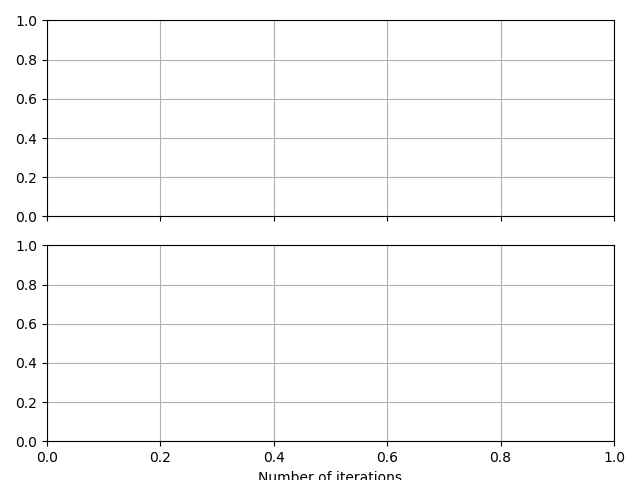

In [160]:
plotter, fig, ax = create_plot(metrics=["loss1", "loss2"])

In [84]:
def train_epoch(epoch, batch_size, log_file=None, eval_every=10):
    
    torch.set_grad_enabled(True)
    model.train()

    idxs = torch.randperm(len(train_images))  # shuffle indices
    
    for itr, batches in enumerate((slice(i, i+batch_size) 
                                 for i in range(0, len(train_images), batch_size))):
        
        #print(type(itr))
        #print(type(batch))
        #print((train_images).shape)
        
        batch = idxs[batches]
        #print((train_images[batch]).shape)
        
        class_predictions, regression_predictions = model(train_images[batch])
        aps, ars = compute_batch_stats(class_predictions, regression_predictions, train_boxes[batch], 
                                       train_labels[batch], feature_map_width=13)
        #print(class_predictions.shape)
        #print(regression_predictions.shape)
        
        #print(train_reg_targs[batch].dtype)
        #print(train_reg_targs[batch].shape)
      
        #print(train_reg_targs.dtype)
        #print(train_reg_targs.shape)
        
        #print(batch.shape)
        
        total_cls_loss, total_reg_loss = loss(class_predictions, regression_predictions, 
                                              train_cls_targs[batch], train_reg_targs[batch])

        optim.zero_grad()
        (total_cls_loss + total_reg_loss).backward()
        optim.step()

        if log_file is not None:
            log_str = f'Epoch {epoch:03d} batch {itr+1:05d}: '
            log_str += f'Loss {(total_cls_loss + total_reg_loss).item():0.4f}'
            log_str += f' Regression loss {total_reg_loss.item():0.4f}'
            log_str += f' Classification loss {total_cls_loss.item():0.4f}'
            log_str += f' AP {np.mean(aps):0.4f} AR {np.mean(ars):0.4f}'
            log_file.write(log_str + '\n')
            
        if (itr + 1) % 10 == 0:
            print(f'Epoch {epoch} iteration {itr + 1}', end='\r')
        plotter.set_train_batch({
                                 "loss1": total_reg_loss.item(),
                                 "loss2": total_cls_loss.item()},batch_size=batch_size)
                                 
    if epoch % eval_every == 0:
        aps, ars = [], []
        idxs = torch.arange(len(val_images))
        for itr, batch in enumerate((slice(i, i+batch_size) 
                                     for i in range(0, len(val_images), batch_size))):
            batch = idxs[batch]

            class_predictions, regression_predictions = model(val_images[batch])
            ap, ar = compute_batch_stats(class_predictions, regression_predictions, 
                                         val_boxes[batch], val_labels[batch], feature_map_width=13)
            aps += ap
            ars += ar
        print(f'Epoch {epoch:03d}  Validation: {np.mean(aps):0.3f} mAP, {np.mean(ars):0.3f} mAR')
        
    plotter.set_train_epoch()

In [157]:
"""load presaved model: 
f = open("model2","rb")
saved_model = pickle.load(f)
f.close()
print(saved_model)"""

'load presaved model: \nf = open("model2","rb")\nsaved_model = pickle.load(f)\nf.close()\nprint(saved_model)'

In [158]:
with open('log.txt', 'w') as log:
    for epoch in range(1, 500):#change back to 101 at some point
        train_epoch(epoch, batch_size, log, eval_every=5)

Epoch 005  Validation: 0.000 mAP, 0.000 mAR
Epoch 010  Validation: 0.000 mAP, 0.000 mAR
Epoch 015  Validation: 0.000 mAP, 0.000 mAR
Epoch 020  Validation: 0.000 mAP, 0.000 mAR
Epoch 025  Validation: 0.000 mAP, 0.000 mAR
Epoch 030  Validation: 0.000 mAP, 0.000 mAR
Epoch 035  Validation: 0.000 mAP, 0.000 mAR
Epoch 040  Validation: 0.000 mAP, 0.000 mAR
Epoch 045  Validation: 0.000 mAP, 0.000 mAR
Epoch 050  Validation: 0.000 mAP, 0.000 mAR
Epoch 055  Validation: 0.000 mAP, 0.000 mAR
Epoch 060  Validation: 0.000 mAP, 0.000 mAR
Epoch 065  Validation: 0.000 mAP, 0.000 mAR
Epoch 070  Validation: 0.000 mAP, 0.000 mAR
Epoch 075  Validation: 0.000 mAP, 0.000 mAR
Epoch 080  Validation: 0.000 mAP, 0.000 mAR
Epoch 085  Validation: 0.000 mAP, 0.000 mAR
Epoch 090  Validation: 0.000 mAP, 0.000 mAR
Epoch 095  Validation: 0.000 mAP, 0.000 mAR
Epoch 100  Validation: 0.000 mAP, 0.000 mAR
Epoch 105  Validation: 0.000 mAP, 0.000 mAR
Epoch 110  Validation: 0.000 mAP, 0.000 mAR
Epoch 115  Validation: 0.000 mAP

KeyboardInterrupt: 

In [ ]:
losses, aps, ars = [], [], []
with open('log.txt') as f:
    for line in f:
        line = line.split()
        losses.append(float(line[5]))
        aps.append(float(line[-3]))
        ars.append(float(line[-1]))

fig, ax = plt.subplots()
ax.scatter(range(len(aps)), aps)
ax.scatter(range(len(ars)), ars)

In [151]:
train_labels

array([array([ 44,  82,  16, 178,  70, 147,  27, 197,  86, 115, 210, 187,  45,
       167,  27, 226, 118, 159, 229, 154, 126,   4]),
       array([ 36,  93, 120,   8, 143, 224,  44,  88, 156, 161, 135, 216, 201,
       144]),
       array([168, 152,  35, 231,  97,  39,  87, 223, 158, 149, 108, 212,  77,
       167,   3, 157,  89, 158, 164,  10,  29]),
       array([ 23, 121, 207,  95, 144,  90, 171, 119, 209, 189,  11, 142,  95,
        32, 218, 139, 170, 192,  67, 198,  82,  56,  45]),
       array([228, 187,  87, 230, 107,  20]), array([160, 186,  34]),
       array([200, 163,  75,  67,  19, 145, 117,  26, 179,  90, 115,   7, 211,
        43, 190, 176, 204, 122, 176, 153, 113]),
       array([113, 106,  65, 177,  65,  96,   3, 156,  84, 200, 102,  82, 104,
       175, 175, 159, 229,  50,  17,  70]),
       array([55]),
       array([198, 131, 149, 180, 161, 174, 147, 109,  88, 126, 191,  45, 207,
       162, 151,  40,  28,  29, 164, 158])], dtype=object)

In [152]:
test2 = 0
def visualize_random_image(model, threshold=0, idx=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    idx = np.random.randint(len(val_images)) if idx is None else idx
    
    #Used to be:
    img = val_images[idx]
#     ax.imshow(img.permute(1, 2, 0).cpu())

    img_raw = val_images_raw[idx].astype(np.integer)
    ax.imshow(img_raw)
    
    
    ax.axis('off')

    out_cls, out_reg = model(img[np.newaxis])
    box_preds, class_preds, scores = compute_detections(out_cls.squeeze(), 
                                                        out_reg.squeeze(), 
                                                        feature_map_width=13,
                                                        anchor_box_step=40, 
                                                        anchor_box_size=80)

    #print(scores)
    keep = scores > threshold
    box_preds = box_preds[keep]
    class_preds = class_preds[keep]
    scores = scores[keep]
    keep_idxs = non_max_suppression(box_preds, scores, threshold=0.1)
    box_preds = box_preds[keep_idxs]
    class_preds = class_preds[keep_idxs]
    
    #print(box_preds)
    test = list()
    #print(class_preds)
    for class_pred, box_pred in zip(class_preds, box_preds):
        if class_pred > 0:
            #print("Here")
            x1, y1, x2, y2 = box_pred
            test.append((x1, y1, x2, y2))
            ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, color='r', fill=None, lw=2))
            label = int(class_pred)
            label = 'vegetable' if label == 1 else label
            label = 'nonmeat protein' if label == 2 else label
            label = 'circle' if label == 3 else label
            ax.annotate(label, (x1, y1), color='r', fontsize=10)
    from collections import Counter
    test2 = Counter(test)
    #print(test2.most_common(len(test2)))

<IPython.core.display.Javascript object>


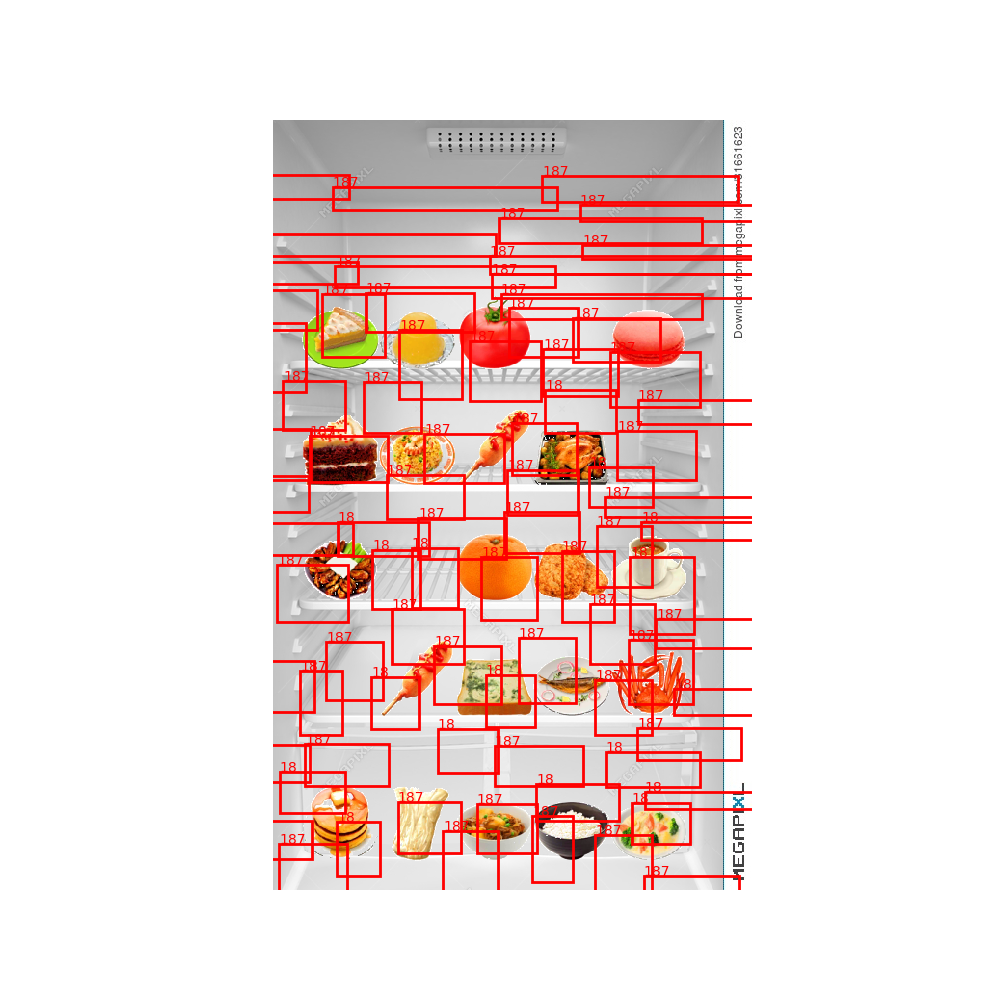

In [154]:
visualize_random_image(model)

In [51]:
output = open("model3.p", "wb")
pickle.dump(model, output)
output.close()